In [1]:
import pandas as pd
import numpy as np

import gc, os, time

import matplotlib.pyplot as plt

In [2]:
# num_rows = 30000
train = pd.read_csv('DATA/train_test/application_train.csv')
test = pd.read_csv('DAtA/train_test/application_test.csv')

# append test to train to process together
df = train.append(test)
# del train, test; gc.collect()

C:\Users\quyk5\AppData\Local\Temp\ipykernel_24280\2084175428.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = train.append(test)


Data cleaning

In [3]:
df = df[df['CODE_GENDER'] != 'XNA']
df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace = True)

<AxesSubplot:ylabel='Frequency'>

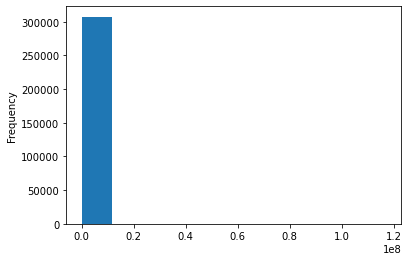

In [4]:
train['AMT_INCOME_TOTAL'].plot.hist()

<AxesSubplot:ylabel='Frequency'>

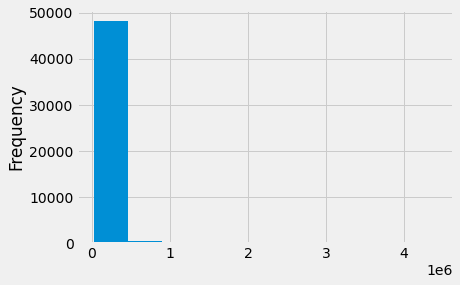

In [42]:
test['AMT_INCOME_TOTAL'].plot.hist()

Flag document features

In [5]:
flag_docs = [doc for doc in df.columns if 'FLAG_DOC' in doc]
df['DOCUMENT_COUNT'] = df[flag_docs].sum(axis = 1)


In [6]:
# df['NEW_DOC_KURT'] = df[flag_docs].kurtosis(axis = 1)
# df['NEW_DOC_KURT'].describe()

count    356251.000000
mean         18.009757
std           5.817179
min           0.000000
25%          20.000000
50%          20.000000
75%          20.000000
max          20.000000
Name: NEW_DOC_KURT, dtype: float64

Affect of age to target

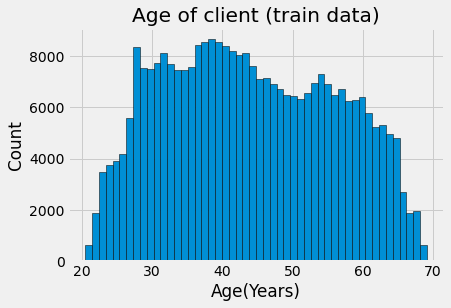

In [20]:
plt.style.use("fivethirtyeight")
train['YEARS_BIRTH'] = train['DAYS_BIRTH'].apply(lambda x: x/(-365))
plt.hist(train['YEARS_BIRTH'], edgecolor = 'k', bins = 50);
plt.title("Age of client (train data)"); plt.xlabel("Age(Years)"); plt.ylabel("Count");

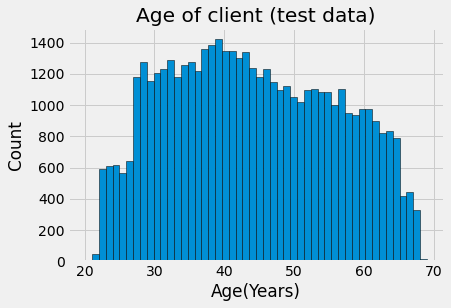

In [21]:
plt.style.use("fivethirtyeight")
test['YEARS_BIRTH'] = test['DAYS_BIRTH'].apply(lambda x: x/(-365))
plt.hist(test['YEARS_BIRTH'], edgecolor = 'k', bins = 50);
plt.title("Age of client (test data)"); plt.xlabel("Age(Years)"); plt.ylabel("Count");

C:\Users\quyk5\AppData\Local\Temp\ipykernel_19592\112212359.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_data['YEARS_BIND'] = pd.cut(age_data['YEARS_BIRTH'], bins= np.linspace(20,70, num= 11))


Text(0.5, 1.0, 'Percent of default bt age group')

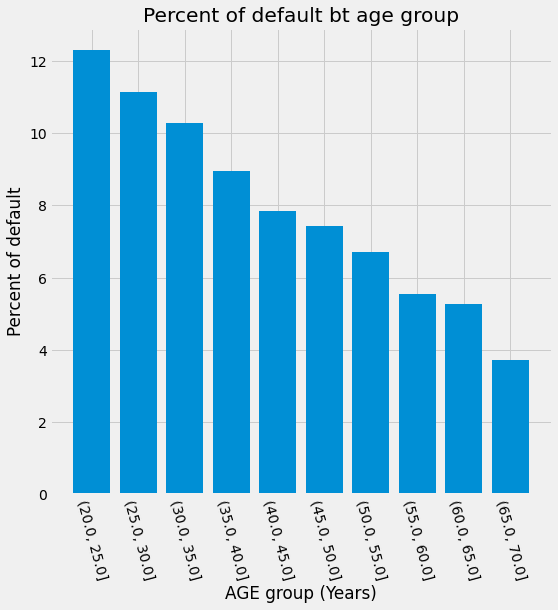

In [19]:
## Calculate percent default according to age bin
age_data = train[['TARGET', 'YEARS_BIRTH']]

# Bin the age data
age_data['YEARS_BIND'] = pd.cut(age_data['YEARS_BIRTH'], bins= np.linspace(20,70, num= 11))

# Group by the bin and calculate mean
age_group = age_data.groupby('YEARS_BIND').mean()

# Visualize 
plt.figure(figsize= (8,8))
plt.bar(age_group.index.astype(str), 100 * age_group['TARGET'])
plt.xticks(rotation = -75); plt.xlabel('AGE group (Years)'); plt.ylabel('Percent of default');
plt.title('Percent of default bt age group')

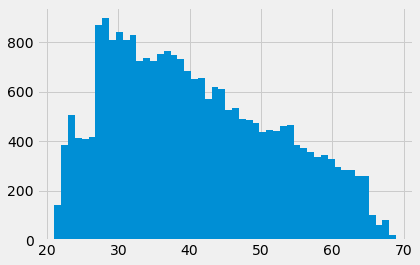

In [54]:
## Plot age group by target = 1
age_target_1 = age_data.loc[age_data['TARGET'] == 1]
age_target_1 = age_target_1.drop('YEARS_BIND', axis= 1)
plt.hist(age_target_1['YEARS_BIRTH'], bins= 50);

In [7]:
def label_age_group(years_birth):
    if years_birth < 27: return 1
    elif years_birth < 40 : return 2
    elif years_birth < 50 : return 3
    elif years_birth < 65: return 4
    elif years_birth < 70: return 5
    else: return 0

In [8]:
df['YEARS_BIRTH'] = df['DAYS_BIRTH'].apply(lambda x: x/(-365))
df['AGE_GROUP'] = df['YEARS_BIRTH'].apply(lambda x: label_age_group(x))


In [14]:
df['YEARS_EMPLOYED'] = df['DAYS_EMPLOYED'].apply(lambda x: x/(-365))

External Source Polynomial

In [9]:
df['EXT_SOURCE_POLY'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']


In [26]:
# For runtimewarning
np.warnings.filterwarnings('ignore', message= 'Mean of empty slice')

for func_name in ['mean', 'max', 'min', 'var']:
    features_name = 'EXT_SOURCE_{}'.format(func_name.upper())
    df[features_name] = eval('np.{}'.format(func_name))( df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']], axis = 1)

Ratio features

In [19]:
# Income
df['ANNUITY_TO_INCOME_RATIO'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
df['CREDIT_TO_INCOME_RATIO'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']
df['INCOME_TO_EMPLOYED_RATIO'] = df['AMT_INCOME_TOTAL'] / df['YEARS_EMPLOYED']
df['INCOME_TO_BIRTH_RATIO'] = df['AMT_INCOME_TOTAL'] / df['YEARS_BIRTH']
df['INCOME_TO_PERSON_RATIO'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']

In [20]:
# Credit
df['CREDIT_TO_ANNUITY_RATIO'] = df['AMT_CREDIT'] / df['AMT_ANNUITY']
df['CREDIT_TO_GOODS_RATIO'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE']

In [21]:
# Time
df['EMPLOYED_TO_BIRTH_RATIO'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
df['CAR_TO_EMPLOYED_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_EMPLOYED']
df['CAR_TO_BIRTH_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_BIRTH']
df['ID_TO_BIRTH_RATIO'] = df['DAYS_ID_PUBLISH'] / df['DAYS_BIRTH']
df['ID_TO_EMPLOYED_RATIO'] = df['DAYS_ID_PUBLISH'] / df['DAYS_EMPLOYED']
df['PHONE_TO_BIRTH_RATIO'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_BIRTH']
df['PHONE_TO_EMPLOYED_RATIO'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_EMPLOYED']

Encoder and drop features

In [49]:
## label encoder

def label_encoder(df):
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']

    for col in categorical_columns:
        df[col], uniques = pd.factorize(df[col])

    return df, categorical_columns

In [40]:
## One hot encoder

def one_hot_encoder(df, nan_as_category = True):

    original_columns = list(df.columns)
    
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']

    # One hot encoder
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)

    # New columns created by get_dummies
    categorical_columns = [col for col in df.columns if col not in original_columns]

    return df, categorical_columns

In [50]:
df, categorical_columns = label_encoder(df)
categorical_columns

['CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE']

Drop some reduncent features

In [51]:
train = df.loc[df['TARGET'].notnull()]
train

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CREDIT_TO_ANNUITY_RATIO,CREDIT_TO_GOODS_RATIO,EMPLOYED_TO_BIRTH_RATIO,CAR_TO_EMPLOYED_RATIO,CAR_TO_BIRTH_RATIO,ID_TO_BIRTH_RATIO,ID_TO_EMPLOYED_RATIO,PHONE_TO_BIRTH_RATIO,PHONE_TO_EMPLOYED_RATIO,EXT_SOURCE_MEAN
0,100002,1.0,0,0,0,0,0,202500.0,406597.5,24700.5,...,16.461104,1.158397,0.067329,NaN,NaN,0.224078,3.328100,0.119860,1.780220,0.161787
1,100003,0.0,0,1,0,1,0,270000.0,1293502.5,35698.5,...,36.234085,1.145199,0.070862,NaN,NaN,0.017358,0.244949,0.049389,0.696970,0.466757
2,100004,0.0,1,0,1,0,0,67500.0,135000.0,6750.0,...,20.000000,1.000000,0.011814,-0.115556,-0.001365,0.132889,11.248889,0.042791,3.622222,0.642739
3,100006,0.0,0,1,0,0,0,135000.0,312682.5,29686.5,...,10.532818,1.052803,0.159905,NaN,NaN,0.128229,0.801909,0.032465,0.203027,0.650442
4,100007,0.0,0,0,0,0,0,121500.0,513000.0,21865.5,...,23.461618,1.000000,0.152418,NaN,NaN,0.173490,1.138249,0.055489,0.364055,0.322738
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307502,456251,0.0,0,0,0,1,0,157500.0,254700.0,27558.0,...,9.242325,1.132000,0.025303,NaN,NaN,0.212501,8.398305,0.029270,1.156780,0.413601
307503,456252,0.0,0,1,0,0,0,72000.0,269550.0,12001.5,...,22.459693,1.198000,NaN,NaN,NaN,0.196871,NaN,-0.000000,NaN,0.115992
307504,456253,0.0,0,1,0,0,0,153000.0,677664.0,29979.0,...,22.604623,1.158400,0.529266,NaN,NaN,0.344113,0.650170,0.127556,0.241005,0.499536
307505,456254,1.0,0,1,0,0,0,171000.0,370107.0,20205.0,...,18.317595,1.158394,0.400134,NaN,NaN,0.077836,0.194526,0.026921,0.067280,0.587593


In [47]:
from sklearn.model_selection import  train_test_split
from sklearn.metrics import  roc_auc_score
import lightgbm as lgb

In [56]:
## Feature importances

# Create model
model = lgb.LGBMClassifier(boosting_type= 'goss', n_estimators= 10000, class_weight= 'balanced', objective= 'binary')

labels = train['TARGET']
train = train.drop('TARGET', axis= 1)

# Empty array to save feature importances values
fi = np.zeros(train.shape[1])

for i in range(2):
    train_features, val_features, train_labels, val_labels = train_test_split(train, labels, test_size= 0.2, random_state= i)

    # Train using early stopping
    model.fit(train_features, train_labels, early_stopping_rounds = 100, eval_set = [(val_features, val_labels)], eval_metric = 'auc')

    # Record the feature importances
    fi += model.feature_importances_

fi = fi/2
fi = pd.DataFrame({'feature': list(train), 'importance': fi}).sort_values('importance', ascending = False)
fi

c:\Users\quyk5\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.730416	valid_0's binary_logloss: 0.677936
[2]	valid_0's auc: 0.735161	valid_0's binary_logloss: 0.665372
[3]	valid_0's auc: 0.737987	valid_0's binary_logloss: 0.65488
[4]	valid_0's auc: 0.740199	valid_0's binary_logloss: 0.645919
[5]	valid_0's auc: 0.741834	valid_0's binary_logloss: 0.638331
[6]	valid_0's auc: 0.742675	valid_0's binary_logloss: 0.631801
[7]	valid_0's auc: 0.743963	valid_0's binary_logloss: 0.626224
[8]	valid_0's auc: 0.744858	valid_0's binary_logloss: 0.621553
[9]	valid_0's auc: 0.745776	valid_0's binary_logloss: 0.617434
[10]	valid_0's auc: 0.746207	valid_0's binary_logloss: 0.613982
[11]	valid_0's auc: 0.74665	valid_0's binary_logloss: 0.61106
[12]	valid_0's auc: 0.747219	valid_0's binary_logloss: 0.608642
[13]	valid_0's auc: 0.747708	valid_0's binary_logloss: 0.606404
[14]	valid_0's auc: 0.748856	valid_0's binary_logloss: 0.604095
[15]	valid_0's auc: 0.750074	valid_0's binary_logloss: 0.602023
[16]	valid_0's auc: 0.750728	valid_0's binary_loglos

c:\Users\quyk5\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.720824	valid_0's binary_logloss: 0.67778
[2]	valid_0's auc: 0.724167	valid_0's binary_logloss: 0.665279
[3]	valid_0's auc: 0.727216	valid_0's binary_logloss: 0.6549
[4]	valid_0's auc: 0.729267	valid_0's binary_logloss: 0.646071
[5]	valid_0's auc: 0.730976	valid_0's binary_logloss: 0.638507
[6]	valid_0's auc: 0.732091	valid_0's binary_logloss: 0.632134
[7]	valid_0's auc: 0.733609	valid_0's binary_logloss: 0.626607
[8]	valid_0's auc: 0.734986	valid_0's binary_logloss: 0.621825
[9]	valid_0's auc: 0.736313	valid_0's binary_logloss: 0.617746
[10]	valid_0's auc: 0.737339	valid_0's binary_logloss: 0.614217
[11]	valid_0's auc: 0.738692	valid_0's binary_logloss: 0.611202
[12]	valid_0's auc: 0.739809	valid_0's binary_logloss: 0.608437
[13]	valid_0's auc: 0.740958	valid_0's binary_logloss: 0.606235
[14]	valid_0's auc: 0.742113	valid_0's binary_logloss: 0.604112
[15]	valid_0's auc: 0.743131	valid_0's binary_logloss: 0.602171
[16]	valid_0's auc: 0.744121	valid_0's binary_loglos

,feature,importance
135,CREDIT_TO_ANNUITY_RATIO,396.0
42,EXT_SOURCE_3,203.0
144,EXT_SOURCE_MEAN,165.0
40,EXT_SOURCE_1,138.0
136,CREDIT_TO_GOODS_RATIO,134.5
...,...,...
24,FLAG_CONT_MOBILE,0.0
22,FLAG_EMP_PHONE,0.0
21,FLAG_MOBIL,0.0
114,FLAG_DOCUMENT_21,0.0


In [57]:
zero_col = list(fi[fi['importance'] == 0.0]['feature'])
print("There are %d features have 0 importace" % len(zero_col))

There are 15 features have 0 importace


In [63]:
fi.reset_index()

,index,feature,importance
0,135,CREDIT_TO_ANNUITY_RATIO,396.0
1,42,EXT_SOURCE_3,203.0
2,144,EXT_SOURCE_MEAN,165.0
3,40,EXT_SOURCE_1,138.0
4,136,CREDIT_TO_GOODS_RATIO,134.5
...,...,...,...
140,24,FLAG_CONT_MOBILE,0.0
141,22,FLAG_EMP_PHONE,0.0
142,21,FLAG_MOBIL,0.0
143,114,FLAG_DOCUMENT_21,0.0


In [67]:
# Drop features correlate to House and Flat
drop_list = [
        'FLAG_EMP_PHONE', 'FLAG_MOBIL', 'FLAG_CONT_MOBILE', 'FLAG_EMAIL', 'FLAG_PHONE',
        'FLAG_OWN_REALTY', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
        'REG_CITY_NOT_WORK_CITY', 'OBS_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE',
        'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_YEAR', 
        'COMMONAREA_MODE', 'NONLIVINGAREA_MODE', 'ELEVATORS_MODE', 'NONLIVINGAREA_AVG',
        'FLOORSMIN_MEDI', 'LANDAREA_MODE', 'NONLIVINGAREA_MEDI', 'LIVINGAPARTMENTS_MODE',
        'FLOORSMIN_AVG', 'LANDAREA_AVG', 'FLOORSMIN_MODE', 'LANDAREA_MEDI',
        'COMMONAREA_MEDI', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'BASEMENTAREA_AVG',
        'BASEMENTAREA_MODE', 'NONLIVINGAPARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 
        'LIVINGAPARTMENTS_AVG', 'ELEVATORS_AVG', 'YEARS_BUILD_MEDI', 'ENTRANCES_MODE',
        'NONLIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'LIVINGAPARTMENTS_MEDI',
        'YEARS_BUILD_MODE', 'YEARS_BEGINEXPLUATATION_AVG', 'ELEVATORS_MEDI', 'LIVINGAREA_MEDI',
        'YEARS_BEGINEXPLUATATION_MODE', 'NONLIVINGAPARTMENTS_AVG', 'HOUSETYPE_MODE',
        'FONDKAPREMONT_MODE', 'EMERGENCYSTATE_MODE', 'HOUR_APPR_PROCESS_START']

# Drop all flag document features
for i in range(2, 22):
    drop_list.append('FLAG_DOCUMENT_{}'.format(i))


In [68]:
df.drop(drop_list, axis= 1, inplace= True)

In [69]:
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,CREDIT_TO_ANNUITY_RATIO,CREDIT_TO_GOODS_RATIO,EMPLOYED_TO_BIRTH_RATIO,CAR_TO_EMPLOYED_RATIO,CAR_TO_BIRTH_RATIO,ID_TO_BIRTH_RATIO,ID_TO_EMPLOYED_RATIO,PHONE_TO_BIRTH_RATIO,PHONE_TO_EMPLOYED_RATIO,EXT_SOURCE_MEAN
0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,351000.0,...,16.461104,1.158397,0.067329,NaN,NaN,0.224078,3.328100,0.119860,1.780220,0.161787
1,100003,0.0,0,1,0,0,270000.0,1293502.5,35698.5,1129500.0,...,36.234085,1.145199,0.070862,NaN,NaN,0.017358,0.244949,0.049389,0.696970,0.466757
2,100004,0.0,1,0,1,0,67500.0,135000.0,6750.0,135000.0,...,20.000000,1.000000,0.011814,-0.115556,-0.001365,0.132889,11.248889,0.042791,3.622222,0.642739
3,100006,0.0,0,1,0,0,135000.0,312682.5,29686.5,297000.0,...,10.532818,1.052803,0.159905,NaN,NaN,0.128229,0.801909,0.032465,0.203027,0.650442
4,100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,513000.0,...,23.461618,1.000000,0.152418,NaN,NaN,0.173490,1.138249,0.055489,0.364055,0.322738


Groupby: Statistics for application in the same group

In [5]:
## Chon ra nhung doi tuong thuoc cung to chuc, hoc van, nghe nghiep, do tuoi, gioi tinh de thong ke
df = pd.read_parquet('TO_TRAIN/train_test.gzip')
group = ['ORGANIZATION_TYPE', 'NAME_EDUCATION_TYPE', 'OCCUPATION_TYPE', 'AGE_GROUP', 'CODE_GENDER']

In [7]:
gb = df[group + ['EXT_SOURCE_MEAN']].groupby(group)['EXT_SOURCE_MEAN'].median().reset_index().rename(columns = {'EXT_SOURCE_MEAN': 'GROUP_EXT_SOURCE_MEAN_MEDIAN'})
df = df.merge(gb, on= group, how= 'left')

In [8]:
gb = df[group + ['EXT_SOURCE_MEAN']].groupby(group)['EXT_SOURCE_MEAN'].std().reset_index().rename(columns = {'EXT_SOURCE_MEAN': 'GROUP_EXT_SOURCE_MEAN_STD'})
df = df.merge(gb, on= group, how= 'left')

In [11]:
df = do_mean(df, group, 'AMT_INCOME_TOTAL', 'GROUP_AMT_INCOME_TOTAL_MEAN')
df = do_std(df, group, 'AMT_INCOME_TOTAL', 'GROUP_AMT_INCOME_TOTAL_STD')

df = do_mean(df, group, 'CREDIT_TO_ANNUITY_RATIO', 'GROUP_CREDIT_TO_ANNUITY_RATIO_MEAN')
df = do_std(df, group, 'CREDIT_TO_ANNUITY_RATIO', 'GROUP_CREDIT_TO_ANNUITY_RATIO_STD')

df = do_mean(df, group, 'AMT_CREDIT', 'GROUP_AMT_CREDIT_MEAN')
df = do_std(df, group, 'AMT_CREDIT', 'GROUP_AMT_CREDIT_STD')

df = do_mean(df, group, 'AMT_ANNUITY', 'GROUP_ANNUITY_MEAN')
df = do_std(df, group, 'AMT_ANNUITY', 'GROUP_ANNUITY_STD')

In [72]:
df.to_parquet('train_test.gzip', compression= 'gzip', index= False)

In [10]:
def do_mean(df, group_cols, counted, agg_name):
    gp = df[group_cols + [counted]].groupby(group_cols)[counted].mean().reset_index().rename(
        columns={counted: agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    gc.collect()
    return df

def do_std(df, group_cols, counted, agg_name):
    gp = df[group_cols + [counted]].groupby(group_cols)[counted].std().reset_index().rename(
        columns={counted: agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    gc.collect()
    return df